### importing packages

In [12]:
import cobra #version 0.26.2
from cobra import Reaction, Metabolite
from cobra import flux_analysis
import numpy as np
import re
import pandas as pd
import matplotlib.pyplot as plt

from scipy import stats

In [13]:
cobra.__version__

'0.26.3'

### importing functions

In [14]:
%run functions.py

### specifying solver

In [15]:
cobra.solver = "glpk"

In [16]:
solver = 'glpk'
# set solver for optimisation
cobra.core.Configuration.solver = solver
model_var = "diel_plant_core_model.xml"

### Loading plant model

In [17]:
diel_model = cobra.io.read_sbml_model(model_var)

#### defining objective reaction

In [18]:
solver = 'glpk'
# set solver for optimisation
cobra.core.Configuration.solver = solver
model_var = "diel_plant_core_model.xml"

# define objective reaction
output_string = "AraCore_Biomass_tx"

day_tag = "_00"
night_tag = "_12"

charge_state_mets = False

### Setting constraints

#### Photorespiration

In [19]:
# photon flux constraints
diel_model.reactions.Photon_tx_00.upper_bound = 200
diel_model.reactions.Photon_tx_12.upper_bound = 0 #night-time darkness

# Rubisco C:O constraint
set_Rubisco_C_to_O_ratio(diel_model, 3/1)

# output day:night
set_output_day_night_ratio(diel_model, 3/1, output_string)

# maintenance day:night
# set_NGAM_day_night_ratio(diel_model, 1/0.5) #setting ATPase fluxes directly instead

#light
PPFD = diel_model.reactions.Photon_tx_00.upper_bound
ATPase = (PPFD*0.0049)+2.7851
print(ATPase)

diel_model.reactions.ATPase_tx_00.bounds = (ATPase, ATPase)

#dark
PPFD = diel_model.reactions.Photon_tx_12.upper_bound
ATPase = (PPFD*0.0049)+2.7851
print(ATPase)

diel_model.reactions.ATPase_tx_12.bounds = (ATPase, ATPase)

# maintenance ATPase:NADPHase
set_NGAM_ATP_NADPH_ratio(diel_model, 3/1)

# nitrate day:night
set_nitrate_uptake_day_night_ratio(diel_model, 3/2)

# amino acids accumulating day to night, not night to day
amino_acids = ["ASN_v",
"SER_v",
"GLN_v",
"GLY_v",
"THR_v",
"L_ALPHA_ALANINE_v",
"VAL_v",
"ILE_v",
"PHE_v",
"LEU_v",
"LYS_v",
"ARG_v",
"L_ASPARTATE_v",
"GLT_v",
"HIS_v",
"bHIS_v",
"MET_v",
"PRO_v",
"TRP_v",
"TYR_v",
"CYS_v"]


for rxn in diel_model.reactions:
    if "_12_to_00" in rxn.id and rxn.id[:-16] in amino_acids:
        rxn.upper_bound = 0
        # print(rxn.id[:-16])
    

3.7651
2.7851


#### other constraints

In [20]:
set_PEPC_C3_constraints(diel_model, slope=2.094050238268857, objective = output_string+"_total")


Setting new PEPC_obj_const constraint, with slope 2.094050238268857 .


(2.094050238268857, '')

## Optimisation of basic diel plant model

In [21]:
model_no_cetch = diel_model.copy()

model_no_cetch.objective = {model_no_cetch.reactions.get_by_id(output_string +"_total") : 1}

# # turn off any phloem output
model_no_cetch.reactions.Phloem_output_tx_00.bounds = (0,0)
model_no_cetch.reactions.Phloem_output_tx_12.bounds = (0,0)

solution_no_cetch = flux_analysis.parsimonious.pfba(model_no_cetch)

In [ ]:
model_no_cetch.reactions.get_by_id(output_string +"_total").flux

0.13033735892900827

In [ ]:
print(model_no_cetch.reactions.CO2_m_00.flux)
print(model_no_cetch.reactions.CO2_mc_00.flux)

2.2368992769661906
0.958671118699796


In [ ]:
model_results_overview(model_no_cetch, solution_no_cetch, output_string+"_total")

Photon uptake = 200.0   % of allowed Photon uptake = 100.0
Output rate (AraCore_Biomass_tx_total) 0.1303		sum of fluxes: 1319.3652
gas exchange = Day: 14.62866 Night: -1.04688
CCE: 0.7755243254716835
ATPase: 3.7651 2.7851
Rubisco Carbox./Oxygen. = 14.7429/4.9143

Linker fluxes 		 Day 	 Night
MAL_v_linker                         0.0                 0.0

GLT_v_linker                         0.0       0.0

CIT_v_linker                         0.0             0.18219

THR_v_linker                     0.01112       0.0

STARCH_p_linker                  0.62104                 0.0

TRP_v_linker                         0.0       0.0

PHE_v_linker                     0.00788       0.0

GLY_v_linker                         0.0       0.0

TYR_v_linker                         0.0       0.0

LYS_v_linker                     0.00861       0.0

4_AMINO_BUTYRATE_v_linker                 0.0             0.00942

FRU_v_linker                         0.0                 0.0

L_ALPHA_ALANINE_v_linker    

/home/corinna/anaconda3/envs/corinna/lib/python3.8/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/corinna/lib/python3.8/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/corinna/lib/python3.8/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


In [ ]:
calculate_noct_CO2_refixation_coefficient(model_no_cetch, verbose=True)

----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.262161
producing HCO3-:	RXN0_5224_c_12	0.262161
producing CO2:	CO2_pc_12	0.590843
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.036981
producing CO2:	GLUTDECARBOX_RXN_c_12	0.012559
producing CO2:	CO2_mc_12	0.512503
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.150609
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.262161
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.005545
----- Plastid -----
producing CO2:	RXN_9652_p_12	0.025127
producing CO2:	RXN_9650_p_12	0.025127
producing CO2:	2.3.1.180_RXN_p_12	0.025127
producing CO2:	RXN_9654_p_12	0.025127
consuming CO2:	RXN0_5224_p_12	0.175892
producing HCO3-:	RXN0_5224_p_12	0.175892
consuming CO2:	CO2_pc_12	0.590843
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.175892
producing CO2:	PYRUVDEH_RXN_p_12	0.208523
producing CO2:	RXN_9653_p_12	0.025127
producing CO2:	RXN_7800_p_12	0.011715
producing CO2:	RXN_9651_p_12	0.025127
producing CO2:	RXN_9648_p_12	0.025127
producing CO2:	6

0.29499856243984657

In [ ]:
calculate_CO2_refixation_coefficient(model_no_cetch, verbose=True)

----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.262161
producing CO2:	CO2_pc_12	0.590843
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.036981
producing CO2:	GLUTDECARBOX_RXN_c_12	0.012559
producing CO2:	CO2_mc_12	0.512503
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.150609
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.005545
----- Plastid -----
producing CO2:	RXN_9652_p_12	0.025127
producing CO2:	RXN_9650_p_12	0.025127
producing CO2:	2.3.1.180_RXN_p_12	0.025127
producing CO2:	RXN_9654_p_12	0.025127
consuming CO2:	RXN0_5224_p_12	0.175892
consuming CO2:	CO2_pc_12	0.590843
producing CO2:	PYRUVDEH_RXN_p_12	0.208523
producing CO2:	RXN_9653_p_12	0.025127
producing CO2:	RXN_7800_p_12	0.011715
producing CO2:	RXN_9651_p_12	0.025127
producing CO2:	RXN_9648_p_12	0.025127
producing CO2:	6PGLUCONDEHYDROG_RXN_p_12	0.348603
producing CO2:	ACETOLACTSYN_RXN_p_12	0.022002
----- Mitochondrion -----
producing CO2:	2KETO_3METHYLVALERATE_RXN_m_12	0.157966
producing CO2:	ISOCITDEH_RXN_

0.29499856243984657

In [ ]:
calculate_CO2_refixation_coefficient(model_no_cetch, verbose=True, time_tag="_00")

----- Cytosol -----
consuming CO2:	RXN0_5224_c_00	0.051236
consuming CO2:	CO2_pc_00	-15.401749
consuming CO2:	ISOCITDEH_RXN_c_00	-0.261929
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_00	0.110944
producing CO2:	CO2_mc_00	0.958671
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_00	0.016635
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_00	0.034449
consuming CO2:	RIBULOSE_BISPHOSPHATE_CARBOXYLASE_RXN_p_00	14.742871
producing CO2:	RXN_9652_p_00	0.075382
producing CO2:	ACETOOHBUTSYN_RXN_p_00	0.179899
producing CO2:	RXN_9650_p_00	0.075382
producing CO2:	2.3.1.180_RXN_p_00	0.075382
producing CO2:	RXN_9654_p_00	0.075382
consuming CO2:	RXN0_5224_p_00	1.500639
producing CO2:	CO2_pc_00	-15.401749
producing CO2:	RXN_9653_p_00	0.075382
producing CO2:	RXN_7800_p_00	0.035145
producing CO2:	RXN_9651_p_00	0.075382
consuming CO2:	CARBAMATE_KINASE_RXN_p_00	0.032948
producing CO2:	RXN_9648_p_00	0.075382
producing CO2:	ACETOLACTSYN_RXN_p_00	0.066005
producing CO2:	CARBOXYCYCLOHEXADIEN

4.484792820891881

In [ ]:
calc_carbon_flux(model_no_cetch, output_string=output_string)

CO2 daytime exchange: 14.62866419280207
CO2 nightime exchange: -1.046879985161285
CO2 respiratory losses: 2.2368992769661906
Carbon day to night: 5.039932523663815
Carbon night to day: 1.1568313058338708
CO2 exchange night:day: 0.22953309402501765
AraCore_Biomass_tx_00 carbon flux: -8.469948073022378
AraCore_Biomass_tx_12 carbon flux: -2.8233160243407927
total carbon biomass flux: -11.29326409736317
total CCE: 0.7755243254716835
nCO2RC: 0.29499856243984657
night CCE: 0.5601892507656755


/home/corinna/anaconda3/envs/corinna/lib/python3.8/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/corinna/lib/python3.8/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/corinna/lib/python3.8/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


,value
CO2 daytime exchange,14.628664
CO2 nightime exchange,-1.046880
Carbon day to night,5.039933
Carbon night to day,1.156831
CO2 exchange night:day,0.229533
day carbon biomass flux,8.469948
night carbon biomass flux,2.823316
total Carbon biomass flux,11.293264
total CCE,0.775524
nCO2RC,0.294999


In [ ]:
model_no_cetch.reactions.get_by_id(output_string +"_total").flux

0.13033735892900827

## CO2 Scan


In [ ]:
df_diel_model_no_cetch, solution_diel_model_no_cetch = parameter_scan_CO2(diel_model, output_string+"_total", "CO2_tx_00", 
                   0, 17, 1, pFBA=True, CO2_refixation_allowed=True, 
                   verbose=True, iterations=50)



Scanning process: CO2_tx_00 

------- Scan iteration: 1      Scan value: 0 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration is infeasible!


------- Scan iteration: 2      Scan value: 1 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.0025995
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.001349
producing HCO3-:	RXN0_5224_c_12	0.001349
producing CO2:	CO2_pc_12	0.315389
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.000738
producing CO2:	CO2_mc_12	0.458952
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.001349
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.000172
producing CO2:	RXN_9652_p_12	0.000501
producing CO2:	RXN_9650_p_12	0.000501
producing CO2:	RXN_5682_p_12	0.000111
producing CO2:	2.3.1.180_RXN_p_12	0.000501
producing CO2:	RXN_9654_p_12	0.000501
consuming CO2:	RXN0_5224_p_12	0.003508
producing HCO3-:	RXN0_5224_p_12	0.003508
consuming CO2:	CO2_pc_12	0.315389
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.003508
producing CO2:	PYRUVDEH_RXN_p_12	0.004009
producing CO2:	RXN_9653_p_12	0.000501
producing CO2:	RXN_9651_p_12	0.000501
consuming 

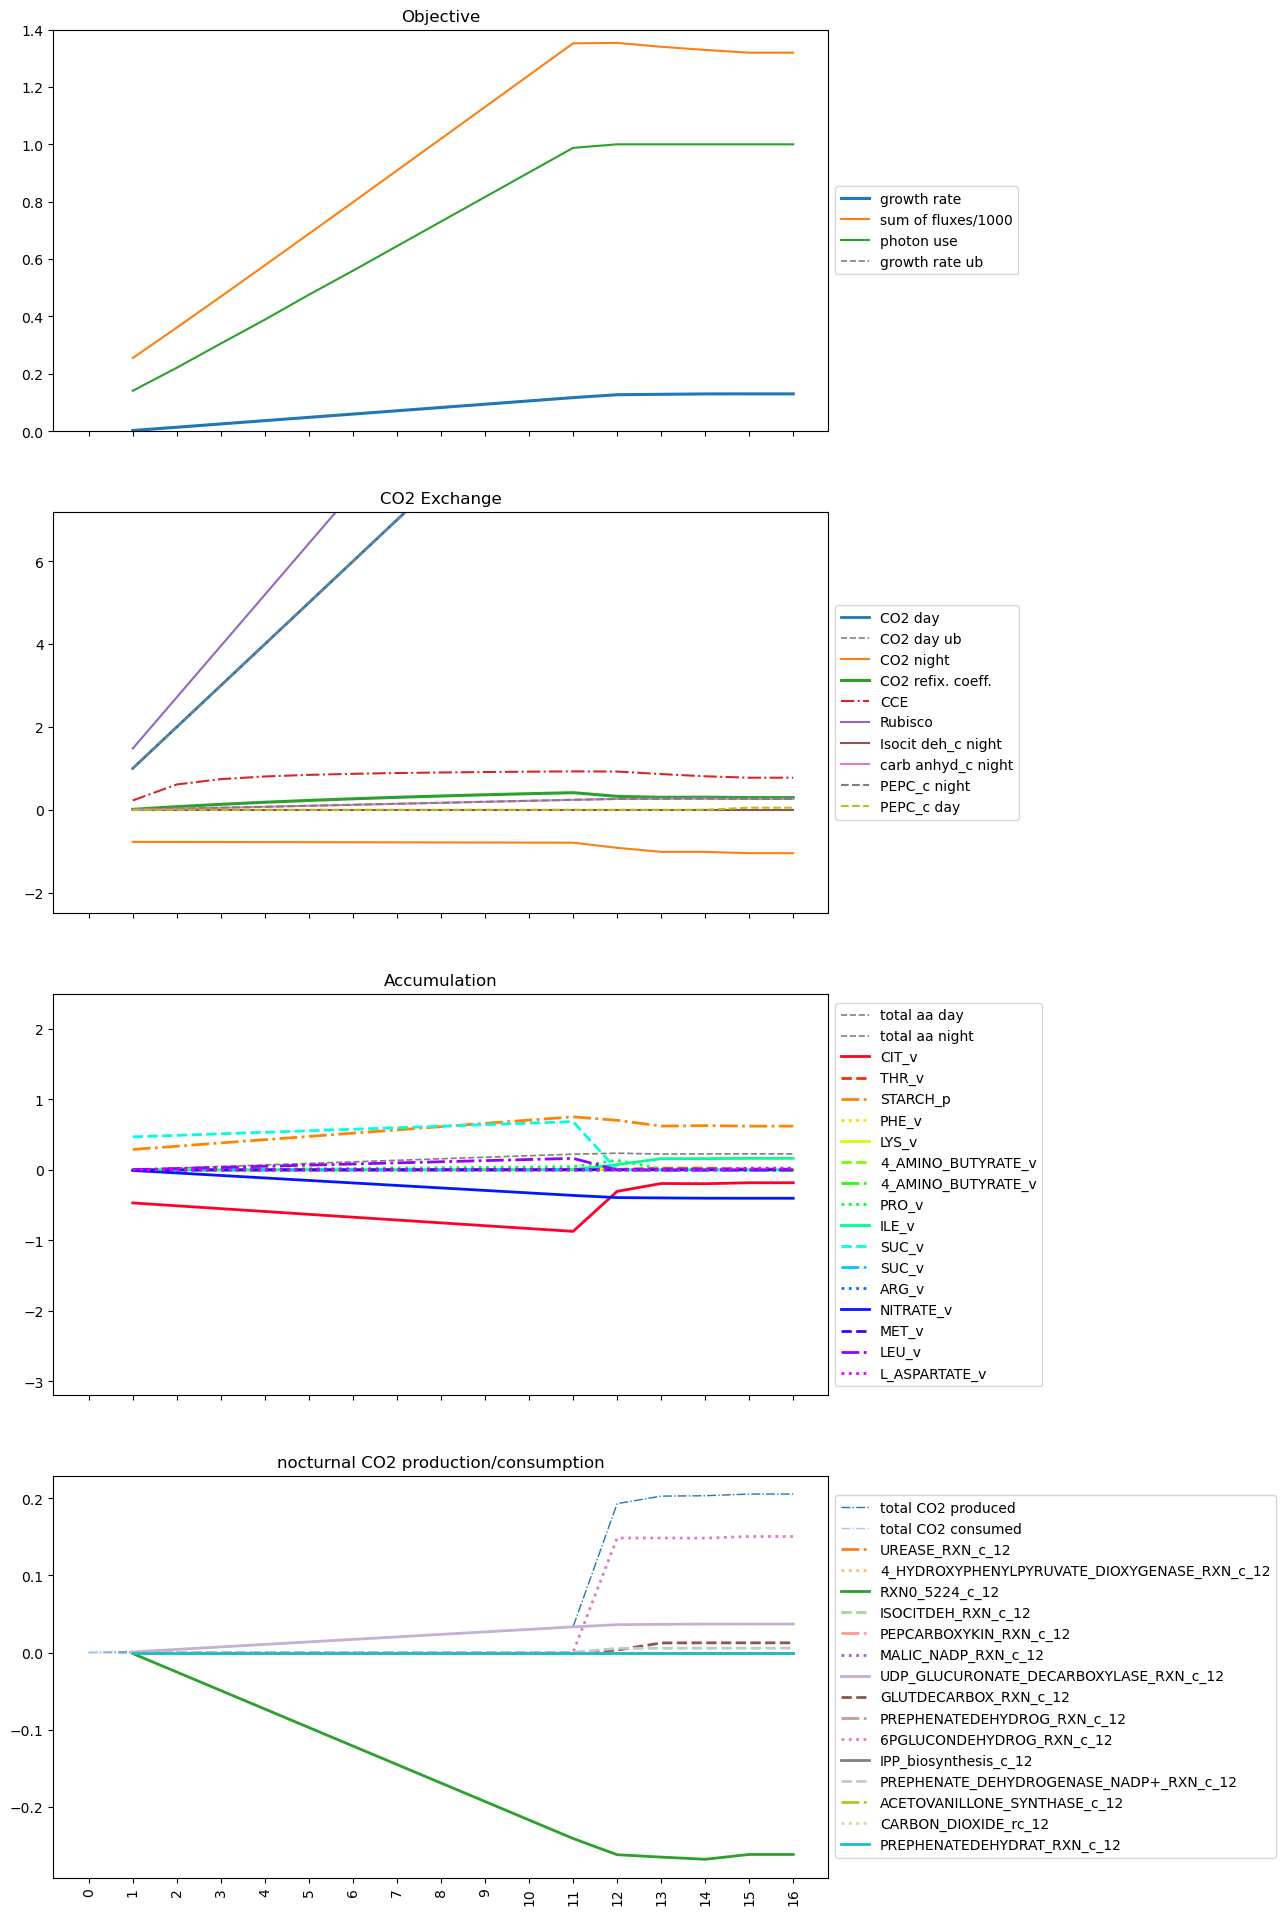

In [ ]:
plot_accum(diel_model, output_string+"_total", df_diel_model_no_cetch, 0.00001, growth_rate=[1,1], CO2_day_rate=[1.16,1.16], lim2_x=0, lim2_y=1.4, lim3_x=-2.5, lim3_y=7.2, lim5_x=-3.2, 
           lim5_y=2.5, time_phase="_12", CO2_organelle = ["_c"])

## Loading and integrating CETCH model

In [ ]:
cetch_model = cobra.io.read_sbml_model("CETCH_cycle.xml")

'' is not a valid SBML 'SId'.
https://identifiers.org/Enzyme Commission Summary/ does not conform to 'http(s)://identifiers.org/collection/id' or'http(s)://identifiers.org/COLLECTION:id
No objective coefficients in model. Unclear what should be optimized


In [ ]:
# remove vinylacetyl-CoA (CPD_226), as it is an intermediate that is not included in any reactions
cetch_model.remove_metabolites([cetch_model.metabolites.CPD_226])

In [ ]:
cetch_dr_dict = {"MALSYN_RXN": [0,1000],
                 "RXN_8961": [0, 1000],
                 "RXN_15977": [0, 1000],
                 "RXN_18384": [0, 1000],
                 "METHYLMALONYL_COA_MUT_RXN": [0, 1000],
                 "RXN_8891": [-1000,0],
                 "RXN_11002": [0, 1000],
                 "RXN_18387": [0, 1000],
                 "RXN_8890": [0, 1000],
                 "RXN_8957": [0, 1000],
                 "RXN_16391": [0, 1000],
                 "RXN_8958": [0, 1000],
                 "RXN_18381": [0, 1000],
                 "RXN_8960": [-1000,0]}

In [ ]:
cetch_model_fw = cetch_model.copy()

for item in cetch_dr_dict:
    cetch_model_fw.reactions.get_by_id(item).bounds = cetch_dr_dict[item]

for rxn in cetch_model_fw.reactions:
    print(rxn.bounds)

(0, 1000)
(0, 1000)
(0, 1000)
(0, 1000)
(0, 1000)
(-1000, 0)
(0, 1000)
(0, 1000)
(0, 1000)
(0, 1000)
(0, 1000)
(0, 1000)
(0, 1000)
(-1000, 0)


In [ ]:
cetch_model = cetch_model_fw

for rxn in cetch_model.reactions:
    print(rxn, rxn.bounds)

MALSYN_RXN: ACETYL_COA + GLYOX + WATER --> CO_A + MAL + PROTON (0, 1000)
RXN_8961: CPD_9409 --> GLYOX + PROPIONYL_COA (0, 1000)
RXN_15977: OXYGEN_MOLECULE + PROPIONYL_COA --> ACRYLYL_COA + HYDROGEN_PEROXIDE (0, 1000)
RXN_18384: ACRYLYL_COA + CARBON_DIOXIDE + NADPH --> METHYL_MALONYL_COA + NADP (0, 1000)
METHYLMALONYL_COA_MUT_RXN: METHYL_MALONYL_COA --> SUC_COA (0, 1000)
RXN_8891: CO_A + NADP + SUCC_S_ALD <-- NADPH + PROTON + SUC_COA (-1000, 0)
RXN_11002: NADPH + PROTON + SUCC_S_ALD --> 4_HYDROXY_BUTYRATE + NADP (0, 1000)
RXN_18387: 4_HYDROXY_BUTYRATE + ATP + CO_A --> 4_HYDROXY_BUTYRYL_COA + ADP + Pi (0, 1000)
RXN_8890: 4_HYDROXY_BUTYRYL_COA --> CROTONYL_COA + WATER (0, 1000)
RXN_8957: CARBON_DIOXIDE + CROTONYL_COA + NADPH --> CPD_9406 + NADP (0, 1000)
RXN_16391: CPD_9406 --> CPD_17635 (0, 1000)
RXN_8958: CPD_17635 --> CPD_9407 (0, 1000)
RXN_18381: CPD_9407 + OXYGEN_MOLECULE --> CPD_9408 + HYDROGEN_PEROXIDE (0, 1000)
RXN_8960: CPD_9409 <-- CPD_9408 + WATER (-1000, 0)


In [ ]:
%run functions.py

In [ ]:
plant_with_pathway_model_day, cetch_model_comp_day = add_pathway_to_compartments(diel_model, 
                                            cetch_model, [ "_00"], ["_p", "_c", "_m", "_x"], transporters=True, 
                                            linkers=True, charge_states=False, charge_states_dict={})

Ignoring reaction 'MALSYN_RXN_x_00' since it already exists.


In [ ]:
df_diel_model_with_cetch_day, solution_diel_model_with_cetch_day = parameter_scan_CO2(plant_with_pathway_model_day, output_string+"_total", "CO2_tx_00", 
                   0, 17, 1, pFBA=True, CO2_refixation_allowed=True, 
                   verbose=True, iterations=50)



Scanning process: CO2_tx_00 

------- Scan iteration: 1      Scan value: 0 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration is infeasible!


------- Scan iteration: 2      Scan value: 1 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.0025995
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.001349
producing HCO3-:	RXN0_5224_c_12	0.001349
producing CO2:	CO2_pc_12	0.315389
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.000738
producing CO2:	CO2_mc_12	0.458952
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.001349
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.000172
producing CO2:	RXN_9652_p_12	0.000501
producing CO2:	RXN_9650_p_12	0.000501
producing CO2:	RXN_5682_p_12	0.000111
producing CO2:	2.3.1.180_RXN_p_12	0.000501
producing CO2:	RXN_9654_p_12	0.000501
consuming CO2:	RXN0_5224_p_12	0.003508
producing HCO3-:	RXN0_5224_p_12	0.003508
consuming CO2:	CO2_pc_12	0.315389
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.003508
producing CO2:	PYRUVDEH_RXN_p_12	0.004009
producing CO2:	RXN_9653_p_12	0.000501
producing CO2:	RXN_9651_p_12	0.000501
consuming 

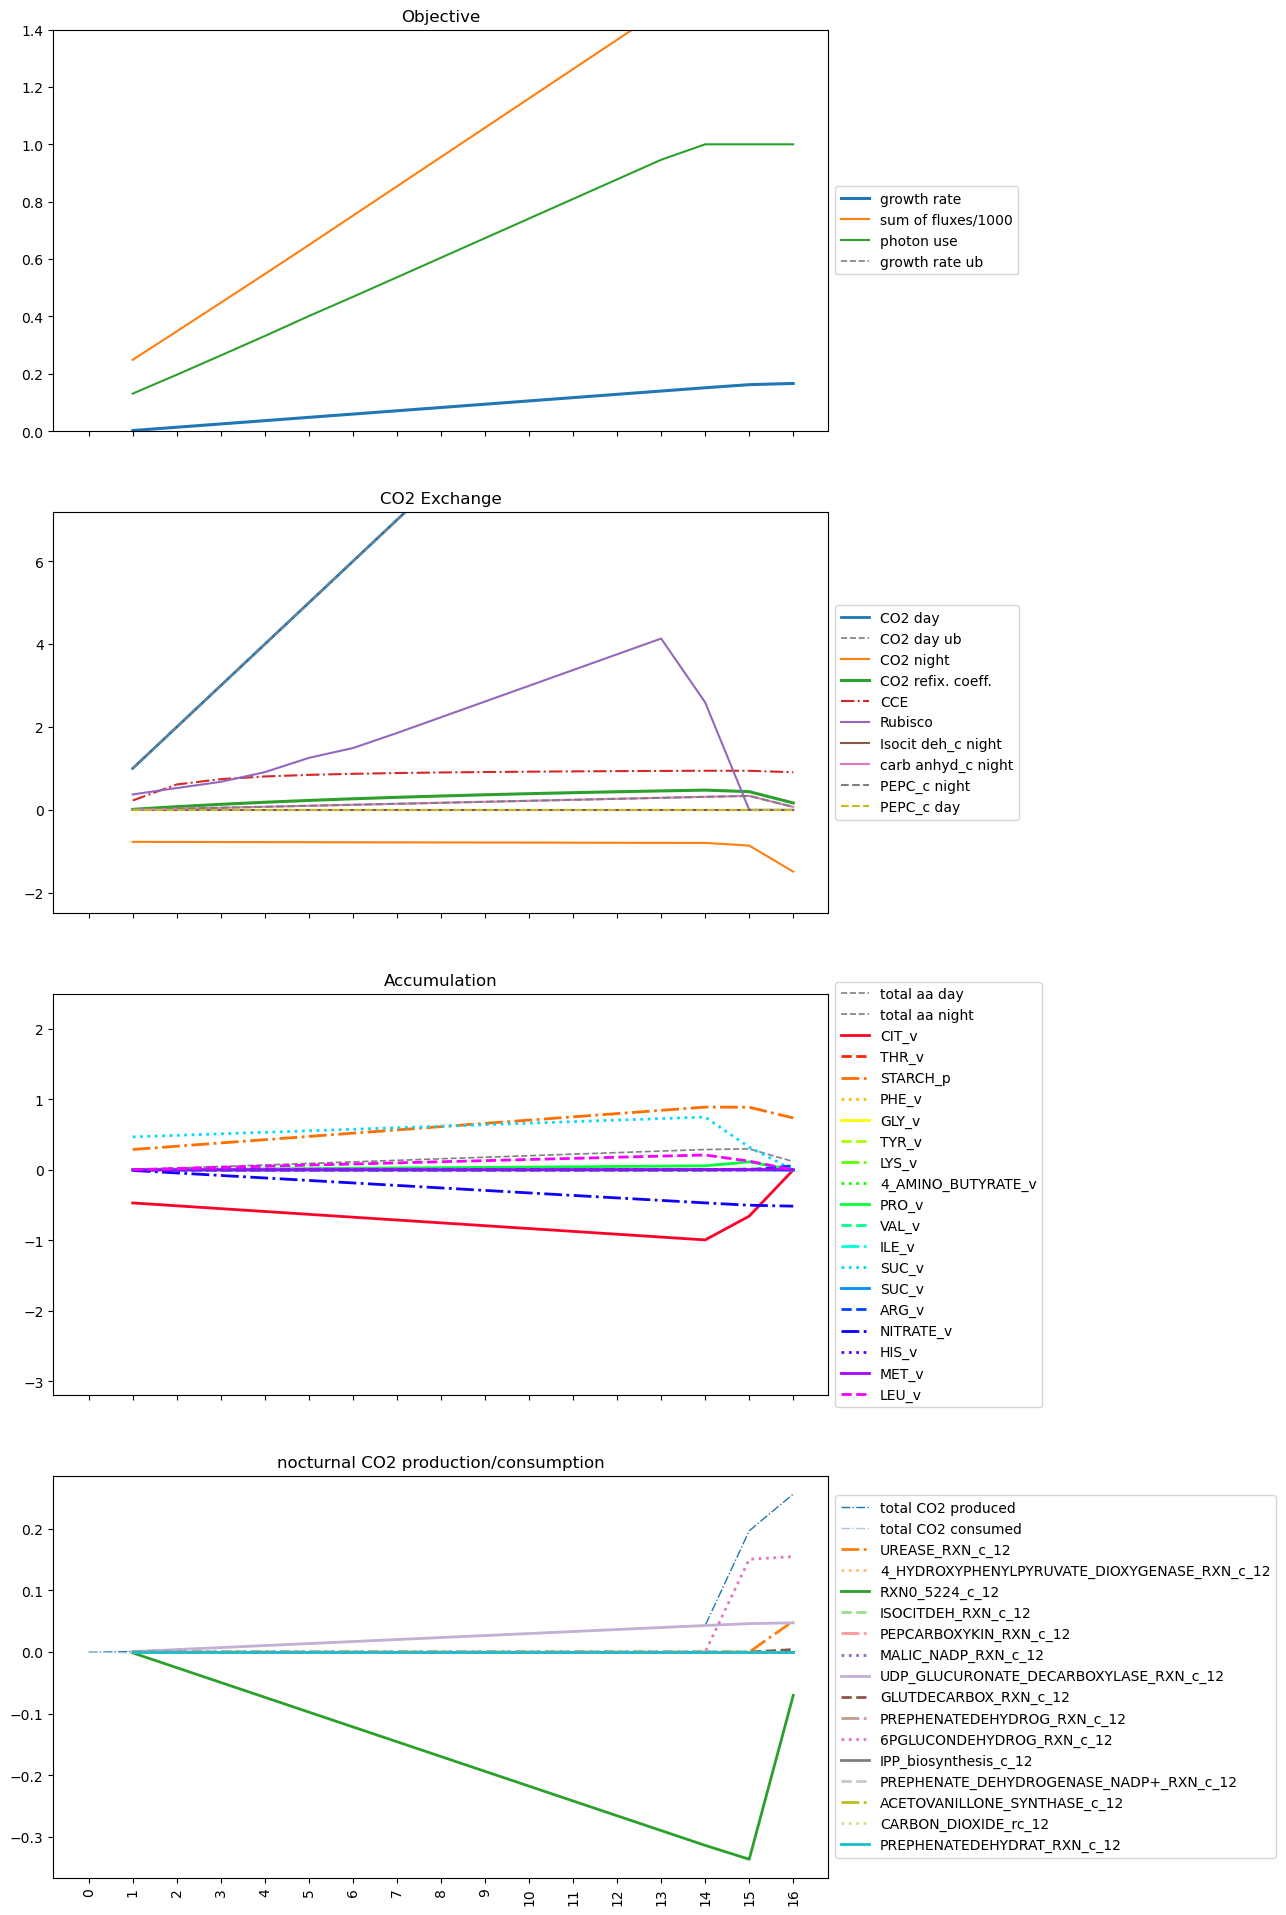

In [ ]:
plot_accum(plant_with_pathway_model_day, output_string+"_total", df_diel_model_with_cetch_day, 0.00001, growth_rate=[1,1], CO2_day_rate=[1.16,1.16], lim2_x=0, lim2_y=1.4, lim3_x=-2.5, lim3_y=7.2, lim5_x=-3.2, 
           lim5_y=2.5, time_phase="_12", CO2_organelle = ["_c"])

PEPC-constrained model with CETCH day only, no CBB (Rubisco inhibited)

In [ ]:
diel_model_noRubisco = diel_model.copy()
diel_model_noRubisco.reactions.RIBULOSE_BISPHOSPHATE_CARBOXYLASE_RXN_p_00.bounds = (0,0)

plant_with_pathway_model_day_noCBB, cetch_model_comp_day_noCBB = add_pathway_to_compartments(diel_model_noRubisco, 
                                            cetch_model, [ "_00"], ["_p", "_c", "_m", "_x"], transporters=True, 
                                            linkers=True, charge_states=False, charge_states_dict={})

Ignoring reaction 'MALSYN_RXN_x_00' since it already exists.


In [ ]:
df_diel_model_with_cetch_day_noCBB, solution_diel_model_with_cetch_day_noCBB = parameter_scan_CO2(plant_with_pathway_model_day_noCBB, output_string+"_total", "CO2_tx_00", 
                   0, 17, 1, pFBA=True, CO2_refixation_allowed=True, 
                   verbose=True, iterations=50)



Scanning process: CO2_tx_00 

------- Scan iteration: 1      Scan value: 0 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration is infeasible!
------- Scan iteration: 2      Scan value: 1 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.0025995
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.001349
producing HCO3-:	RXN0_5224_c_12	0.001349
producing CO2:	CO2_pc_12	0.315389
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.000738
producing CO2:	CO2_mc_12	0.458952
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.001349
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.000172
producing CO2:	RXN_9652_p_12	0.000501
producing CO2:	RXN_9650_p_12	0.000501
producing CO2:	RXN_5682_p_12	0.000111
producing CO2:	2.3.1.180_RXN_p_12	0.000501
producing CO2:	RXN_9654_p_12	0.000501
consuming CO2:	RXN0_5224_p_12	0.003508
producing HCO3-:	RXN0_5224_p_12	0.003508
consuming CO2:	CO2_pc_12	0.315389
consuming HCO3-:	ACETYL_COA_

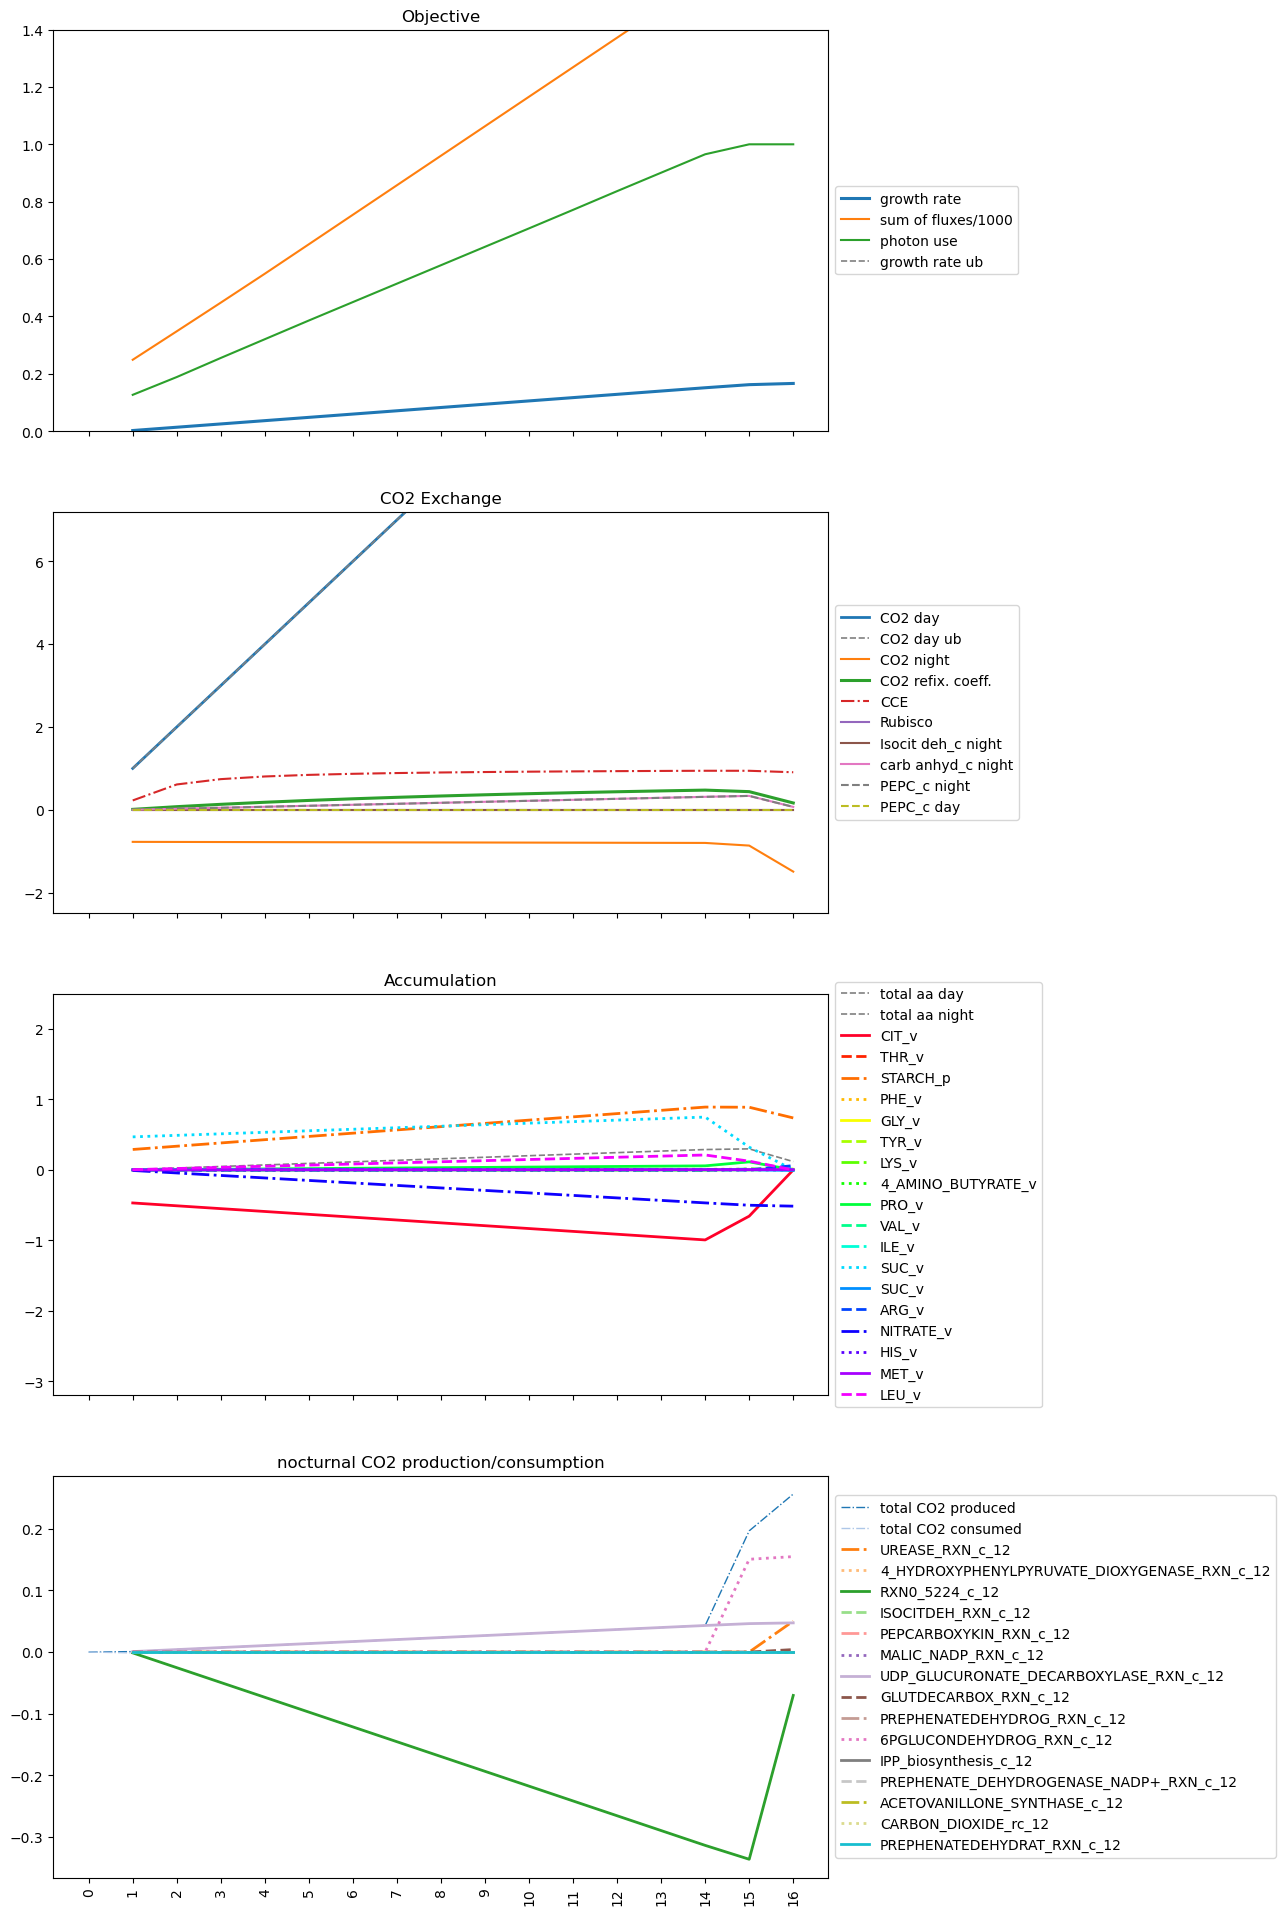

In [ ]:
plot_accum(plant_with_pathway_model_day_noCBB, output_string+"_total", df_diel_model_with_cetch_day_noCBB, 0.00001, growth_rate=[1,1], CO2_day_rate=[1.16,1.16], lim2_x=0, lim2_y=1.4, lim3_x=-2.5, lim3_y=7.2, lim5_x=-3.2, 
           lim5_y=2.5, time_phase="_12", CO2_organelle = ["_c"])

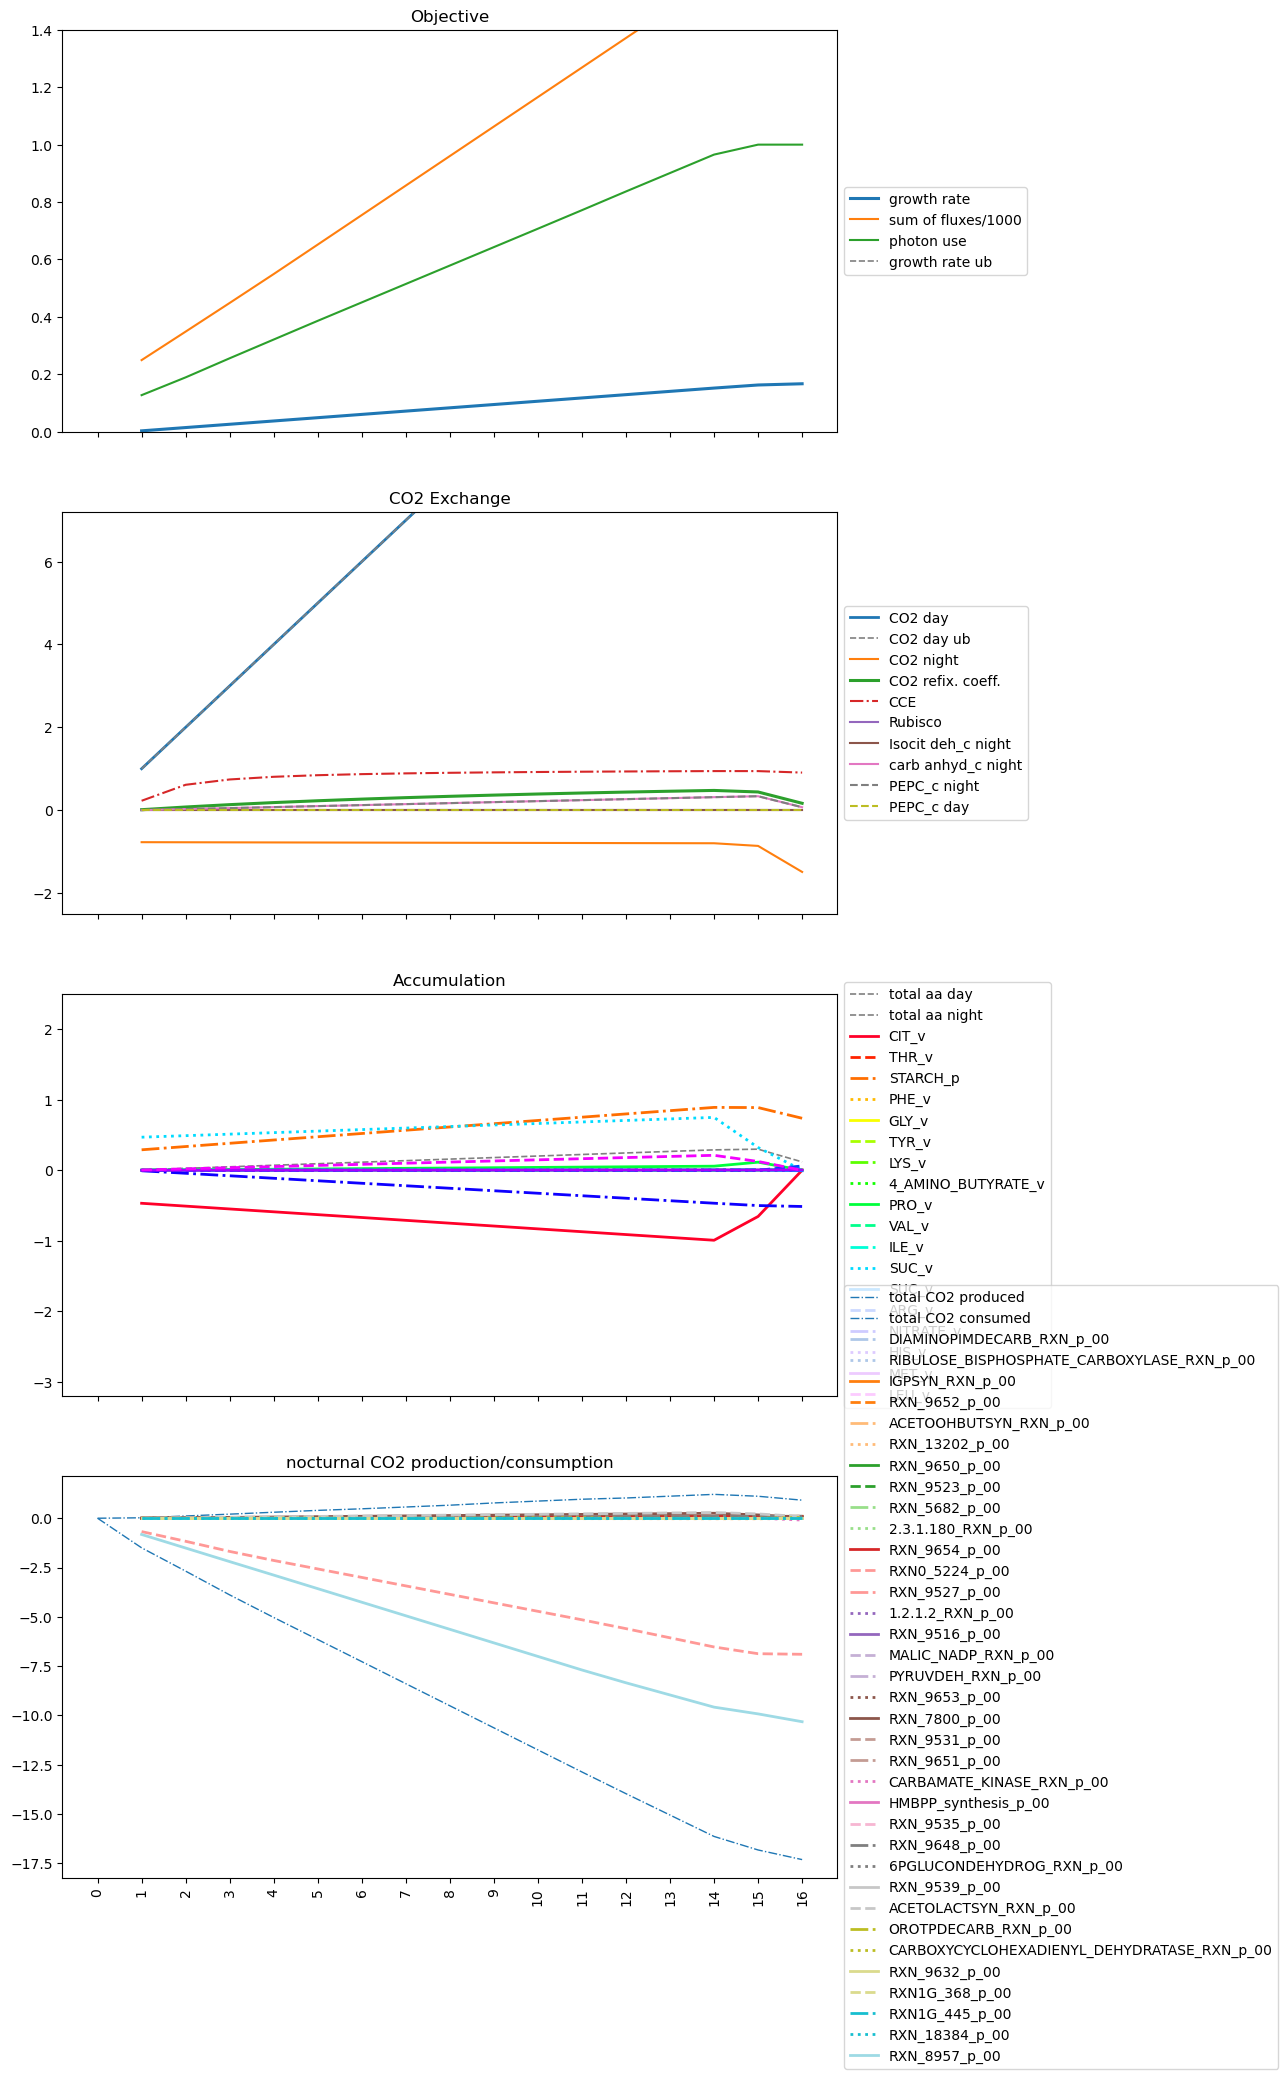

In [ ]:
plot_accum(plant_with_pathway_model_day_noCBB, output_string+"_total", df_diel_model_with_cetch_day_noCBB, 0.00001, growth_rate=[1,1], CO2_day_rate=[1.16,1.16], lim2_x=0, lim2_y=1.4, lim3_x=-2.5, lim3_y=7.2, lim5_x=-3.2, 
           lim5_y=2.5, time_phase="_00", CO2_organelle = ["_p"])

In [ ]:
plant_with_pathway_model_night, cetch_model_comp_night = add_pathway_to_compartments(diel_model, 
                                            cetch_model, [ "_12"], ["_p", "_c", "_m", "_x"], transporters=True, 
                                            linkers=True, charge_states=False, charge_states_dict={})

Ignoring reaction 'MALSYN_RXN_x_12' since it already exists.


In [ ]:
for rxn in cetch_model.reactions:
    print(rxn)

MALSYN_RXN: ACETYL_COA + GLYOX + WATER --> CO_A + MAL + PROTON
RXN_8961: CPD_9409 --> GLYOX + PROPIONYL_COA
RXN_15977: OXYGEN_MOLECULE + PROPIONYL_COA --> ACRYLYL_COA + HYDROGEN_PEROXIDE
RXN_18384: ACRYLYL_COA + CARBON_DIOXIDE + NADPH --> METHYL_MALONYL_COA + NADP
METHYLMALONYL_COA_MUT_RXN: METHYL_MALONYL_COA --> SUC_COA
RXN_8891: CO_A + NADP + SUCC_S_ALD <-- NADPH + PROTON + SUC_COA
RXN_11002: NADPH + PROTON + SUCC_S_ALD --> 4_HYDROXY_BUTYRATE + NADP
RXN_18387: 4_HYDROXY_BUTYRATE + ATP + CO_A --> 4_HYDROXY_BUTYRYL_COA + ADP + Pi
RXN_8890: 4_HYDROXY_BUTYRYL_COA --> CROTONYL_COA + WATER
RXN_8957: CARBON_DIOXIDE + CROTONYL_COA + NADPH --> CPD_9406 + NADP
RXN_16391: CPD_9406 --> CPD_17635
RXN_8958: CPD_17635 --> CPD_9407
RXN_18381: CPD_9407 + OXYGEN_MOLECULE --> CPD_9408 + HYDROGEN_PEROXIDE
RXN_8960: CPD_9409 <-- CPD_9408 + WATER


In [ ]:
df_diel_model_with_cetch_night, solution_diel_model_with_cetch_night = parameter_scan_CO2(plant_with_pathway_model_night, output_string+"_total", "CO2_tx_00", 
                   0, 17, 1, pFBA=True, CO2_refixation_allowed=True, 
                   verbose=True, iterations=50)



Scanning process: CO2_tx_00 

------- Scan iteration: 1      Scan value: 0 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration is infeasible!
------- Scan iteration: 2      Scan value: 1 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.0059943
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.008458
producing HCO3-:	RXN0_5224_c_12	0.008458
producing CO2:	CO2_pc_12	0.323875
consuming CO2:	CO2_xc_12	-4.066086
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.001701
producing CO2:	CO2_mc_12	12.348923
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.008458
consuming CO2:	RXN_8957_c_12	8.121713
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.000396
producing CO2:	RXN_9652_p_12	0.001156
producing CO2:	RXN_9650_p_12	0.001156
producing CO2:	RXN_5682_p_12	0.000255
producing CO2:	2.3.1.180_RXN_p_12	0.001156
producing CO2:	RXN_9654_p_12	0.001156
consuming CO2:	RXN0_5224_p_12	0.008089
producing HCO3-:	RXN0_5224_p_

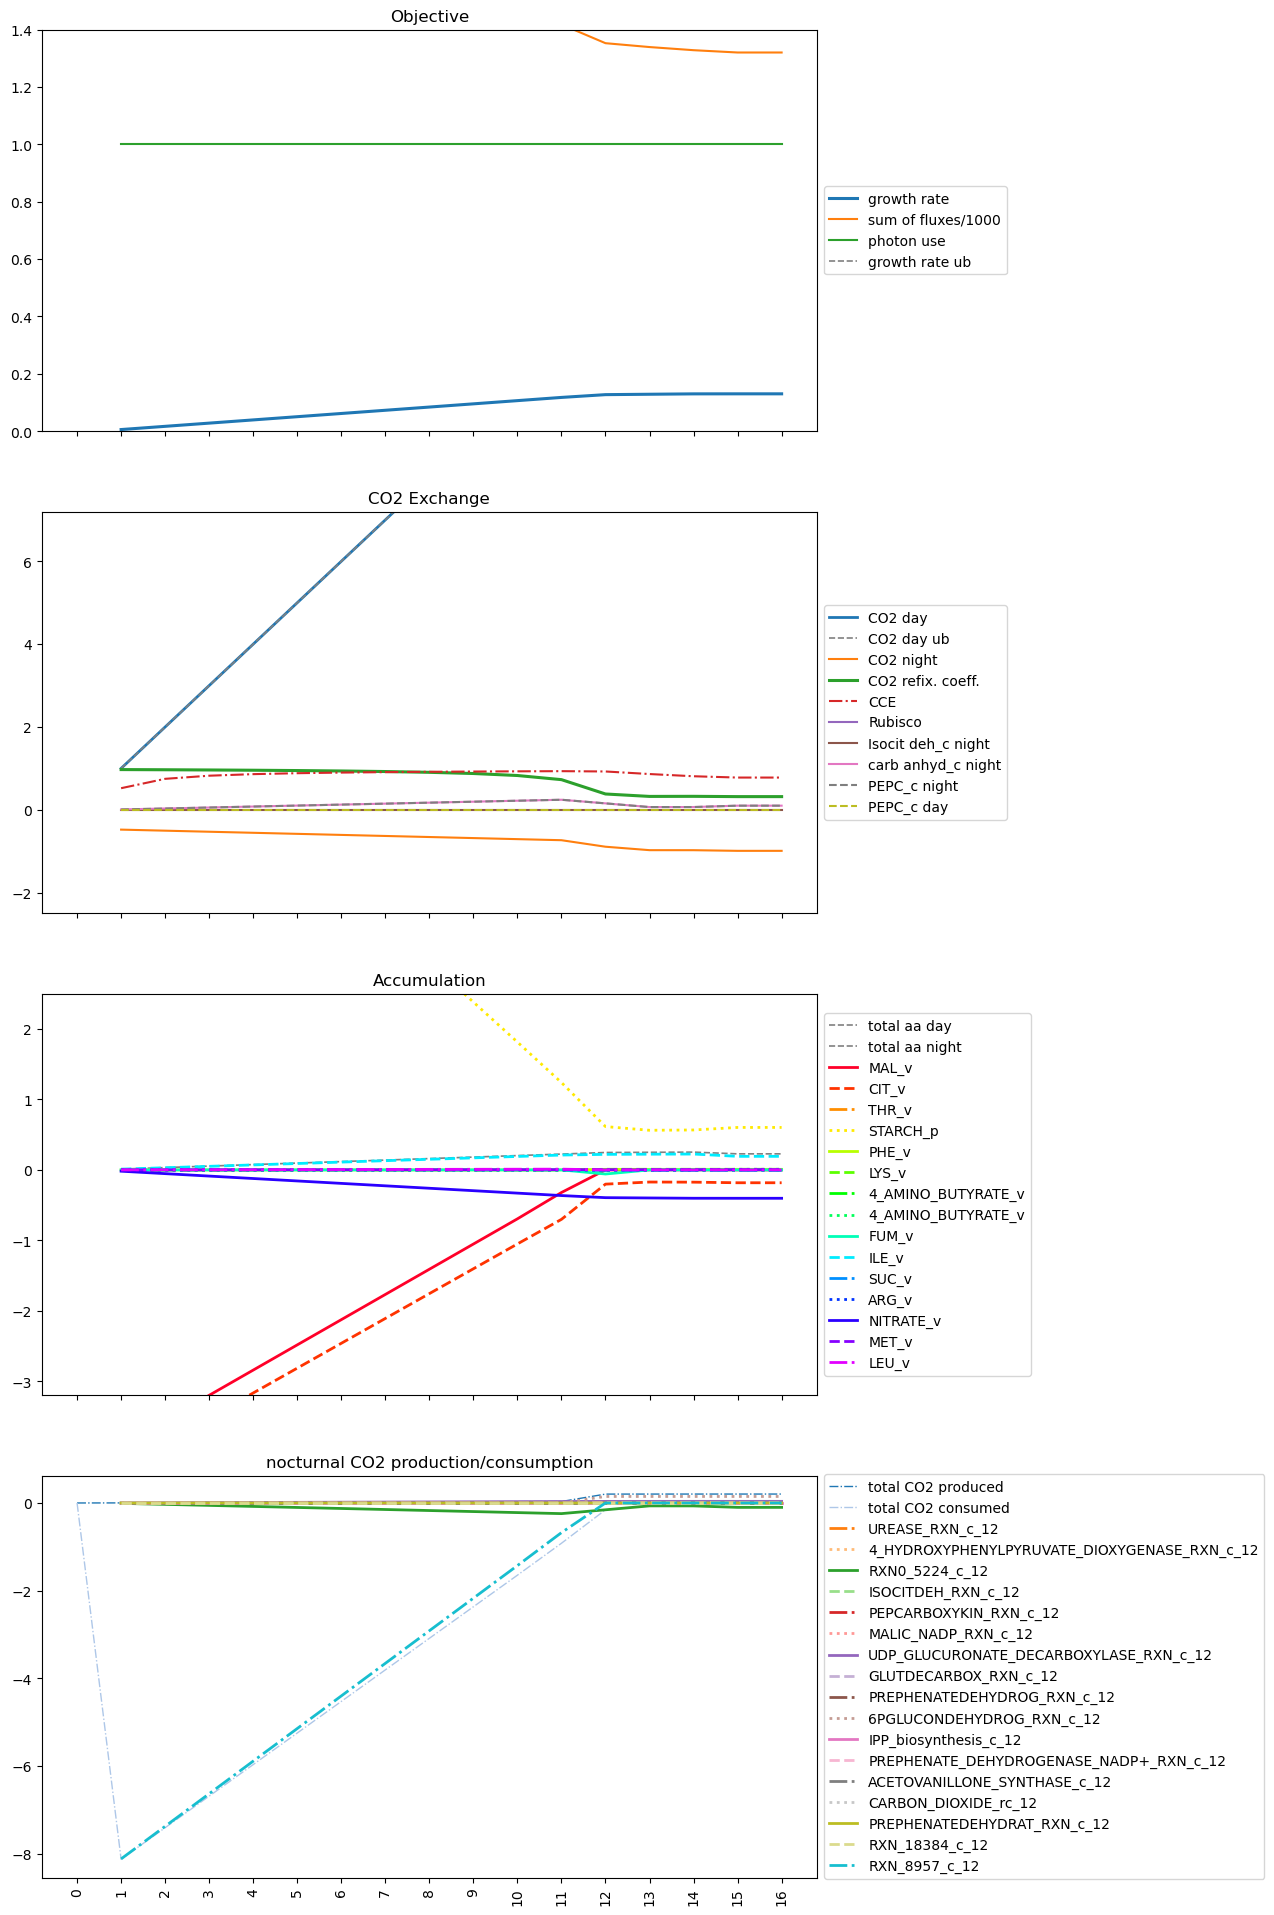

In [ ]:
plot_accum(plant_with_pathway_model_night, output_string+"_total", df_diel_model_with_cetch_night, 0.00001, growth_rate=[1,1], CO2_day_rate=[1.16,1.16], lim2_x=0, lim2_y=1.4, lim3_x=-2.5, lim3_y=7.2, lim5_x=-3.2, 
           lim5_y=2.5, time_phase="_12", CO2_organelle = ["_c"])

In [ ]:
plant_with_pathway_model_2, cetch_model_comp_2 = add_pathway_to_compartments(diel_model, 
                                            cetch_model, ["_00", "_12"], ["_p", "_c", "_m", "_x"], transporters=True, 
                                            linkers=True, charge_states=False, charge_states_dict={})

Ignoring reaction 'MALSYN_RXN_x_00' since it already exists.
Ignoring reaction 'MALSYN_RXN_x_12' since it already exists.


In [ ]:
df_diel_model_with_cetch_2, solution_diel_model_with_cetch_2 = parameter_scan_CO2(plant_with_pathway_model_2, output_string+"_total", "CO2_tx_00", 
                   0, 17, 1, pFBA=True, CO2_refixation_allowed=True, 
                   verbose=True, iterations=50)



Scanning process: CO2_tx_00 

------- Scan iteration: 1      Scan value: 0 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration is infeasible!
------- Scan iteration: 2      Scan value: 1 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.0114886
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.019964
producing HCO3-:	RXN0_5224_c_12	0.019964
producing CO2:	CO2_pc_12	0.277269
consuming CO2:	CO2_xc_12	-0.400628
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.00326
producing CO2:	GLUTDECARBOX_RXN_c_12	0.11614
producing CO2:	CO2_mc_12	0.256367
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.432832
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.019964
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.000489
consuming CO2:	RXN_8957_c_12	0.665765
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.000759
producing CO2:	RXN_9652_p_12	0.002215
producing CO2:	RXN_9650_p_12	0.002215
producing CO2:	2.3.1.180_RXN_p

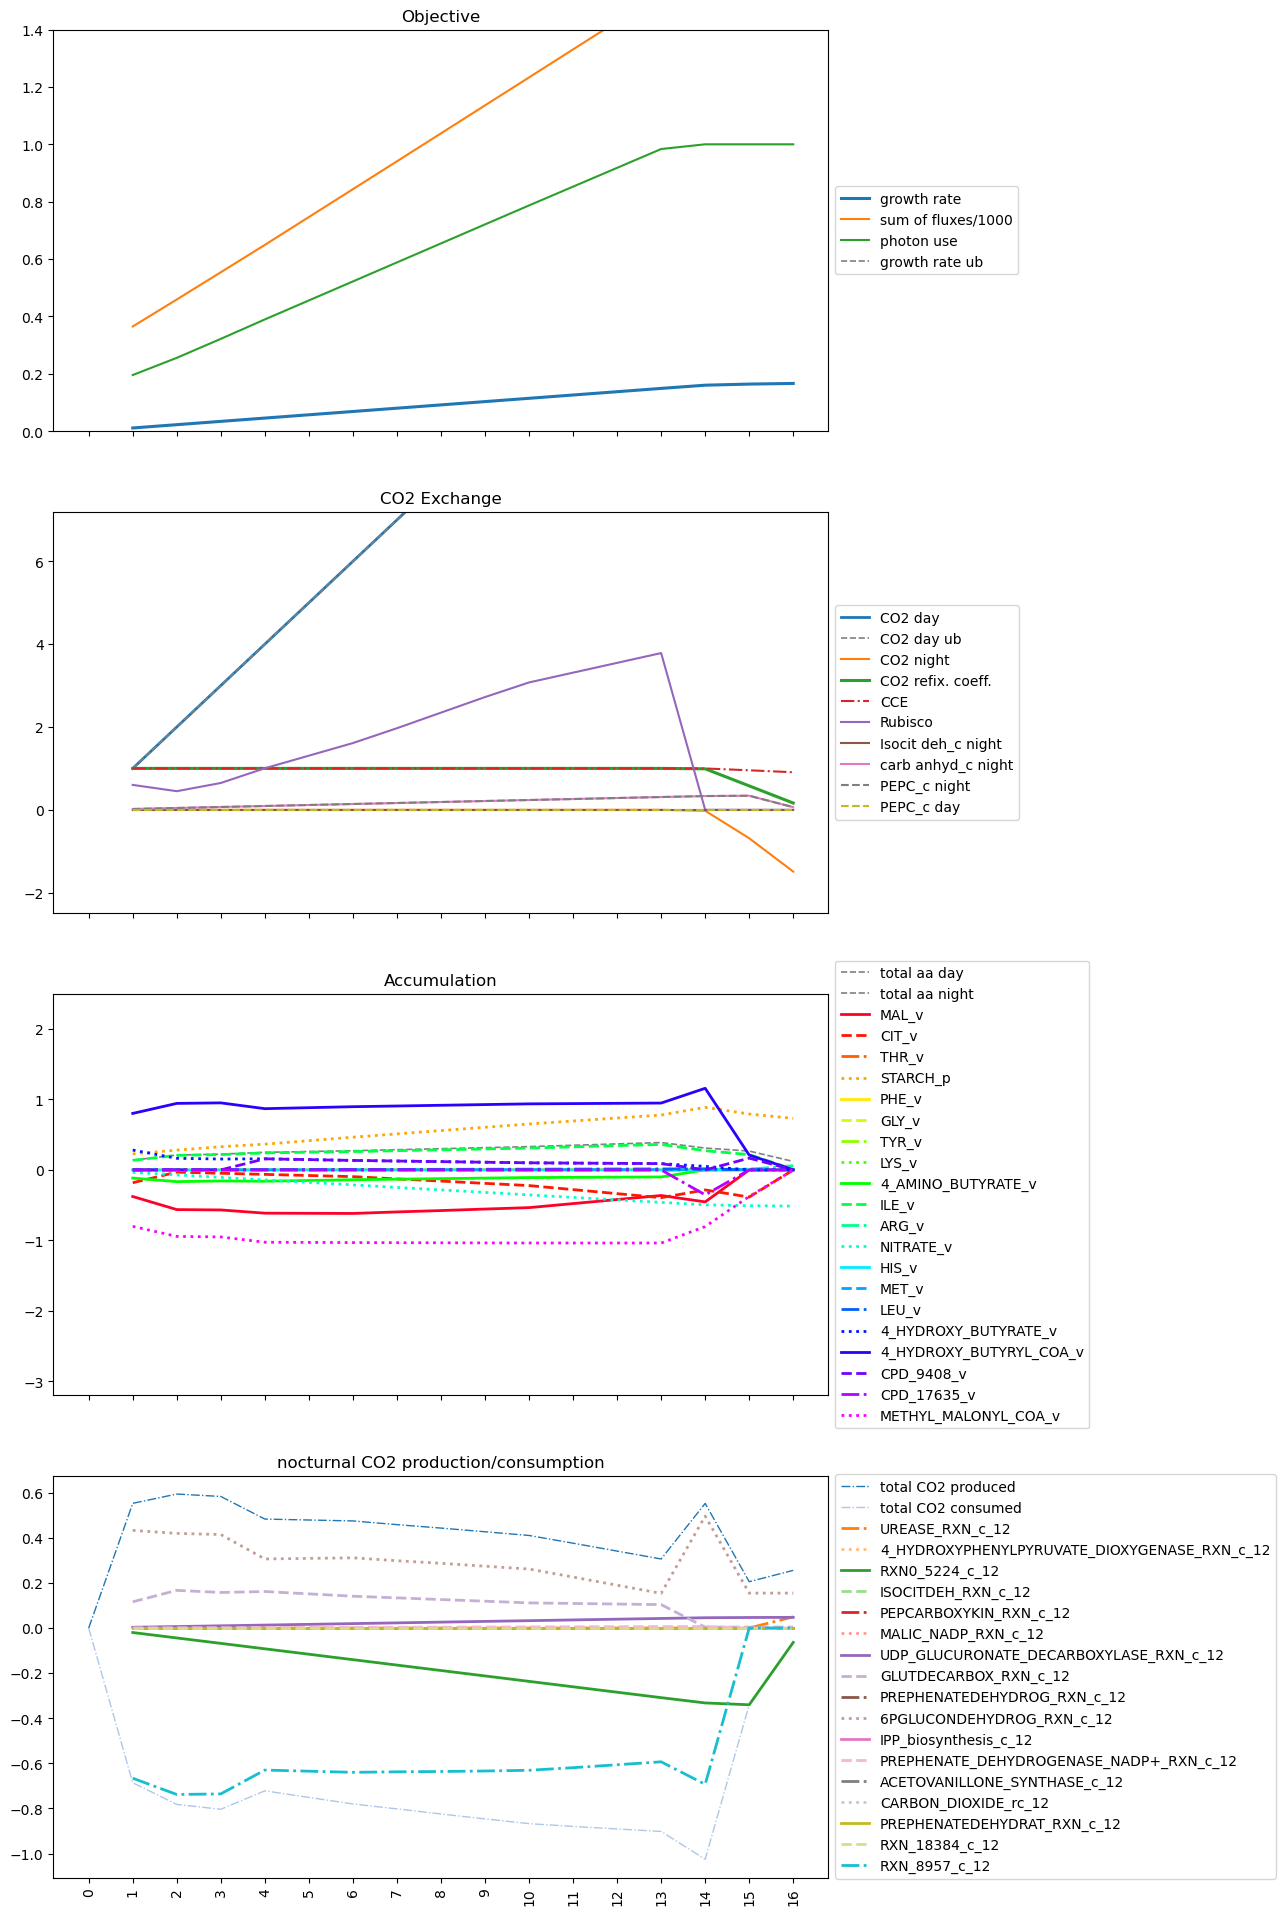

In [ ]:
plot_accum(plant_with_pathway_model_2, output_string+"_total", df_diel_model_with_cetch_2, 0.00001, growth_rate=[1,1], CO2_day_rate=[1.16,1.16], lim2_x=0, lim2_y=1.4, lim3_x=-2.5, lim3_y=7.2, lim5_x=-3.2, 
           lim5_y=2.5, time_phase="_12", CO2_organelle = ["_c"])

In [ ]:
diel_model_CAM = diel_model.copy()
diel_model_CAM.remove_cons_vars(diel_model_CAM.constraints.PEPC_obj_const)

df_diel_model_CAM, solution_diel_model_CAM = parameter_scan_CO2(diel_model_CAM, output_string+"_total", "CO2_tx_00", 
                   0, 17, 1, pFBA=True, CO2_refixation_allowed=True, 
                   verbose=True, iterations=50)



Scanning process: CO2_tx_00 

------- Scan iteration: 1      Scan value: 0 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.0
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	1.153565
producing HCO3-:	RXN0_5224_c_12	1.153565
producing CO2:	CO2_pc_12	0.171579
producing CO2:	CO2_mc_12	0.827257
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.154728
consuming HCO3-:	PEPCARBOX_RXN_c_12	1.153565
----- Plastid -----
consuming CO2:	CO2_pc_12	0.171579
producing CO2:	6PGLUCONDEHYDROG_RXN_p_12	0.171579
----- Mitochondrion -----
producing CO2:	ISOCITDEH_RXN_m_12	0.275752
producing CO2:	PYRUVDEH_RXN_m_12	0.275752
producing CO2:	2OXOGLUTARATEDEH_RXN_m_12	0.275752
consuming CO2:	CO2_mc_12	0.827257
----- Peroxisome -----

CO2 produced: 1.15356
CO2 consumed: -1.15356
CO2 exchange: 0.0

nocturnal CO2 refixation coeffient: 1.0
------- Scan iteration: 2      Scan value: 1 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Obje

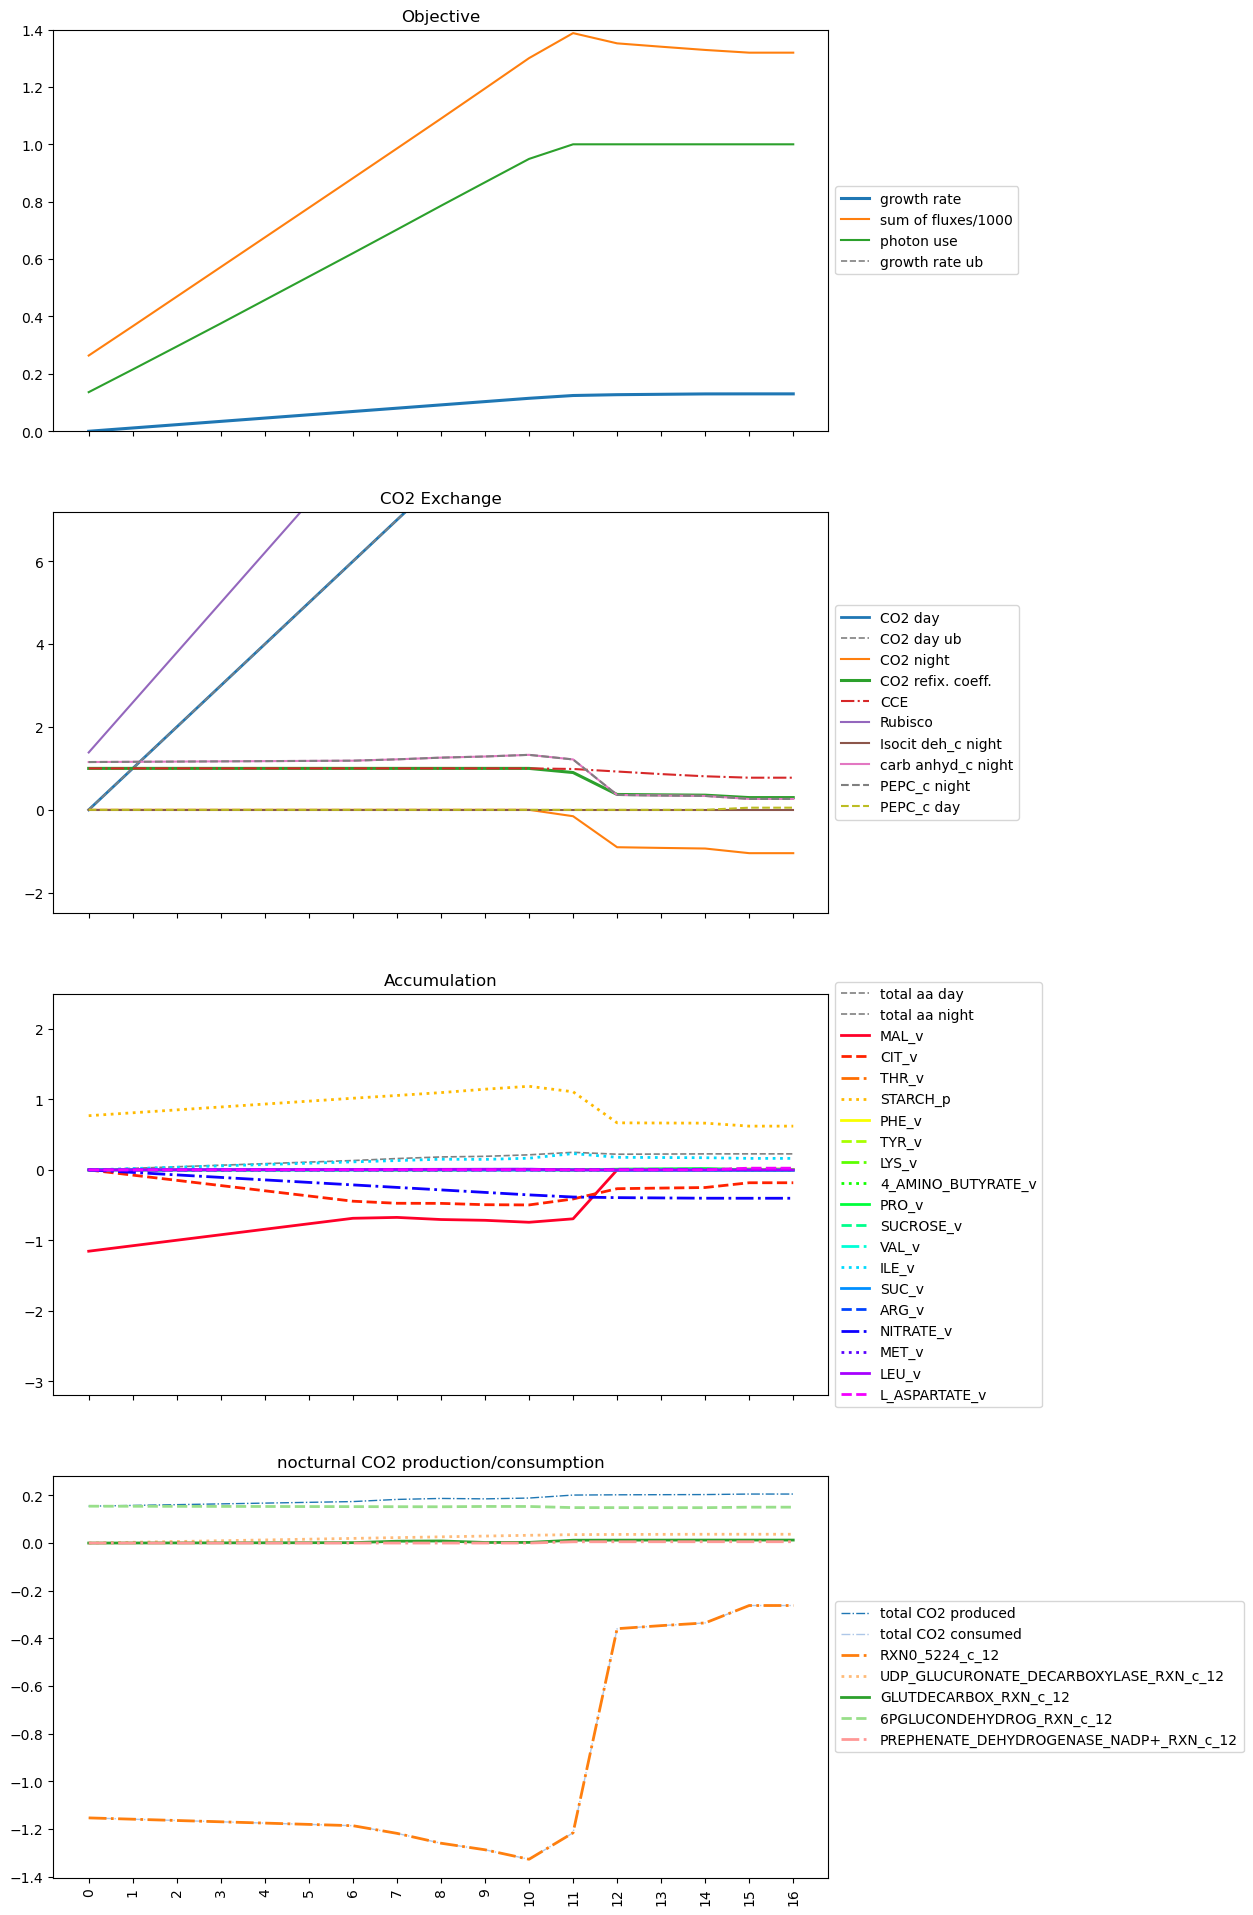

In [ ]:
plot_accum(diel_model, output_string+"_total", df_diel_model_CAM, 0.00001, growth_rate=[1,1], CO2_day_rate=[1.16,1.16], lim2_x=0, lim2_y=1.4, lim3_x=-2.5, lim3_y=7.2, lim5_x=-3.2, 
           lim5_y=2.5, time_phase="_12", CO2_organelle = ["_c"])

In [ ]:
# model without Rubisco

diel_model_noRubisco = diel_model.copy()
diel_model_noRubisco.reactions.RIBULOSE_BISPHOSPHATE_CARBOXYLASE_RXN_p_00.bounds = (0,0)

df_diel_model_noRubisco, solution_diel_model_noRubisco = parameter_scan_CO2(diel_model_noRubisco, output_string+"_total", "CO2_tx_00", 
                   0, 17, 1, pFBA=True, CO2_refixation_allowed=True, 
                   verbose=True, iterations=50)



Scanning process: CO2_tx_00 

------- Scan iteration: 1      Scan value: 0 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration is infeasible!
------- Scan iteration: 2      Scan value: 1 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration is infeasible!
------- Scan iteration: 3      Scan value: 2 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration is infeasible!
------- Scan iteration: 4      Scan value: 3 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration is infeasible!
------- Scan iteration: 5      Scan value: 4 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration is infeasible!
------- Scan iteration: 6      Scan value: 5 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration is infeasible!
------- Scan iteration: 7      Scan value: 6 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration is infeasible!
------- Scan iteration: 8      Scan val

StopIteration: 

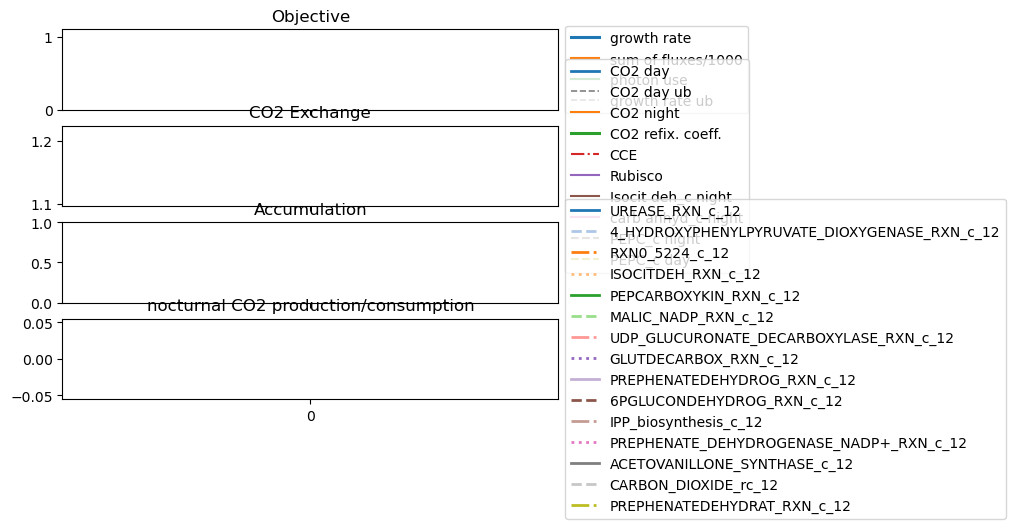

In [ ]:
plot_accum(diel_model_noRubisco, output_string+"_total", df_diel_model_noRubisco, 0.00001, growth_rate=[1,1], CO2_day_rate=[1.16,1.16], lim2_x=0, lim2_y=1.4, lim3_x=-2.5, lim3_y=7.2, lim5_x=-3.2, 
           lim5_y=2.5, time_phase="_12", CO2_organelle = ["_c"])

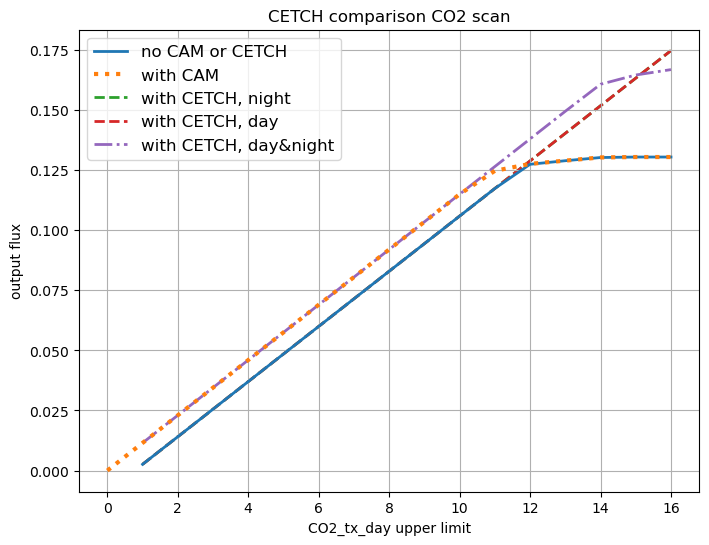

In [ ]:
import matplotlib.pyplot as plt

x = range(0,17,1)
a = df_diel_model_no_cetch.transpose()[output_string+"_total"]
b = df_diel_model_with_cetch.transpose()[output_string+"_total"]
c = df_diel_model_with_cetch_2.transpose()[output_string+"_total"]
d = df_diel_model_CAM.transpose()[output_string+"_total"]

plt.figure(figsize=(8, 6))
plt.plot(x, a, label="no CAM or CETCH", linewidth=2, zorder=2)
plt.plot(x, d, label="with CAM", linewidth=3, zorder=4, linestyle=":")
plt.plot(x, b, label="with CETCH, night", linewidth=2, zorder=1, linestyle="--")
plt.plot(x, b, label="with CETCH, day", linewidth=2, zorder=1, linestyle="--")
plt.plot(x, c, label="with CETCH, day&night", linewidth=2, zorder=3, linestyle="-.")

plt.xlabel("CO2_tx_day upper limit")
plt.ylabel("output flux")
plt.title("CETCH comparison CO2 scan")
plt.legend(fontsize=12)
plt.grid(True, zorder=0)
plt.show()


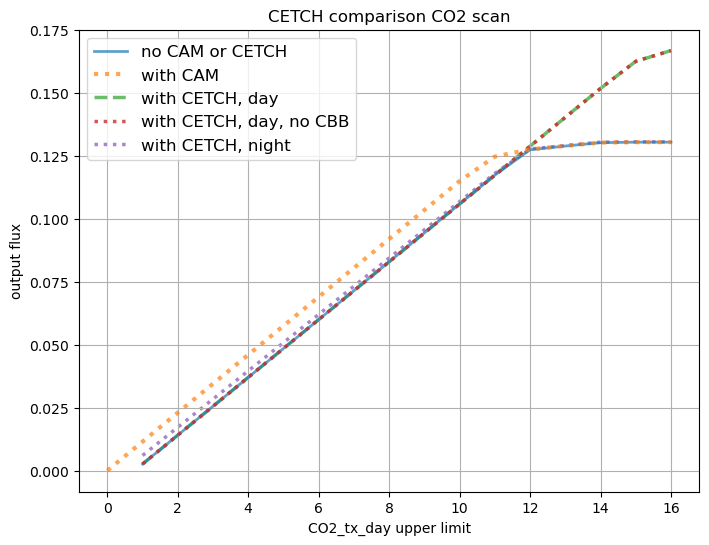

In [ ]:
import matplotlib.pyplot as plt

x = range(0,17,1)
a = df_diel_model_no_cetch.transpose()[output_string+"_total"]
b = df_diel_model_with_cetch_night.transpose()[output_string+"_total"]
c = df_diel_model_with_cetch_day.transpose()[output_string+"_total"]
d = df_diel_model_with_cetch_2.transpose()[output_string+"_total"]
e = df_diel_model_CAM.transpose()[output_string+"_total"]
f = df_diel_model_with_cetch_day_noCBB.transpose()[output_string+"_total"]

plt.figure(figsize=(8, 6))
plt.plot(x, a, label="no CAM or CETCH", linewidth=2, zorder=2, alpha=0.7)
plt.plot(x, e, label="with CAM", linewidth=3, zorder=4, linestyle=":", alpha=0.7)
plt.plot(x, c, label="with CETCH, day", linewidth=2.5, zorder=1, linestyle="--", alpha=0.7)
plt.plot(x, f, label="with CETCH, day, no CBB", linewidth=2.5, zorder=3, linestyle=":", alpha=0.8)

plt.plot(x, b, label="with CETCH, night", linewidth=2.5, zorder=1, linestyle=":", alpha=0.8)
# plt.plot(x, d, label="with CETCH, day&night", linewidth=2.4, zorder=3, linestyle="-.", alpha=0.7)


plt.xlabel("CO2_tx_day upper limit")
plt.ylabel("output flux")
plt.title("CETCH comparison CO2 scan")
plt.legend(fontsize=12)
plt.grid(True, zorder=0)
plt.show()




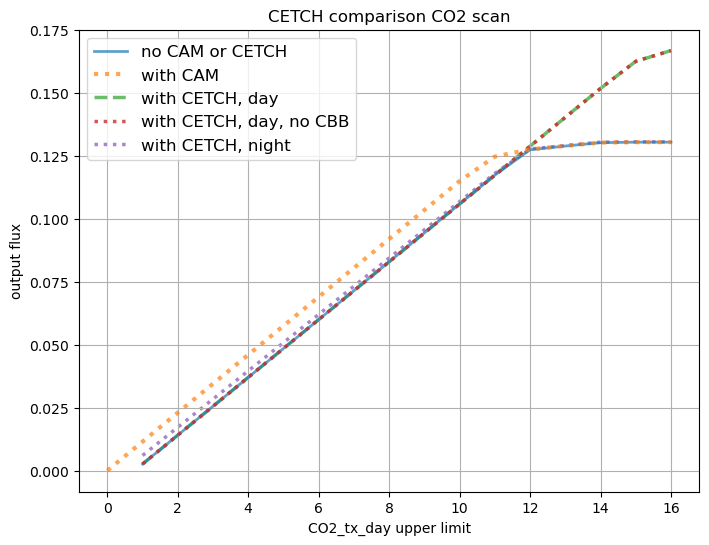

In [ ]:
import matplotlib.pyplot as plt

x = range(0,17,1)
a = df_diel_model_no_cetch.transpose()[output_string+"_total"]
b = df_diel_model_with_cetch_night.transpose()[output_string+"_total"]
c = df_diel_model_with_cetch_day.transpose()[output_string+"_total"]
d = df_diel_model_with_cetch_2.transpose()[output_string+"_total"]
e = df_diel_model_CAM.transpose()[output_string+"_total"]
f = df_diel_model_with_cetch_day_noCBB.transpose()[output_string+"_total"]

plt.figure(figsize=(8, 6))
plt.plot(x, a, label="no CAM or CETCH", linewidth=2, zorder=2, alpha=0.7)
plt.plot(x, e, label="with CAM", linewidth=3, zorder=4, linestyle=":", alpha=0.7)
plt.plot(x, c, label="with CETCH, day", linewidth=2.5, zorder=1, linestyle="--", alpha=0.7)
plt.plot(x, f, label="with CETCH, day, no CBB", linewidth=2.5, zorder=3, linestyle=":", alpha=0.8)

plt.plot(x, b, label="with CETCH, night", linewidth=2.5, zorder=1, linestyle=":", alpha=0.8)
# plt.plot(x, d, label="with CETCH, day&night", linewidth=2.4, zorder=3, linestyle="-.", alpha=0.7)


plt.xlabel("CO2_tx_day upper limit")
plt.ylabel("output flux")
plt.title("CETCH comparison CO2 scan")
plt.legend(fontsize=12)
plt.grid(True, zorder=0)
plt.show()


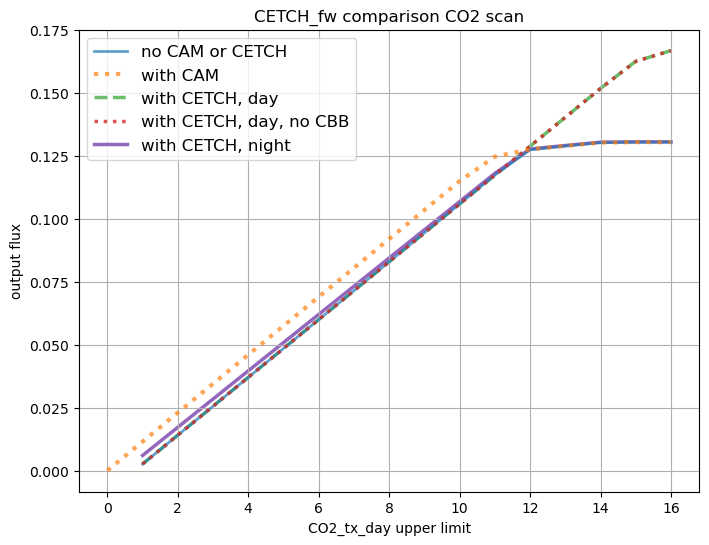

In [ ]:
import matplotlib.pyplot as plt

x = range(0,17,1)
a = df_diel_model_no_cetch.transpose()[output_string+"_total"]
b = df_diel_model_with_cetch_night.transpose()[output_string+"_total"]
c = df_diel_model_with_cetch_day.transpose()[output_string+"_total"]
d = df_diel_model_with_cetch_2.transpose()[output_string+"_total"]
e = df_diel_model_CAM.transpose()[output_string+"_total"]
f = df_diel_model_with_cetch_day_noCBB.transpose()[output_string+"_total"]
g = df_diel_model_noRubisco.transpose()[output_string+"_total"]

plt.figure(figsize=(8, 6))
plt.plot(x, a, label="no CAM or CETCH", linewidth=2, zorder=2, alpha=0.7)
plt.plot(x, e, label="with CAM", linewidth=3, zorder=4, linestyle=":", alpha=0.7)
plt.plot(x, c, label="with CETCH, day", linewidth=2.5, zorder=1, linestyle="--", alpha=0.7)
plt.plot(x, f, label="with CETCH, day, no CBB", linewidth=2.5, zorder=3, linestyle=":", alpha=0.8)

plt.plot(x, b, label="with CETCH, night", linewidth=2.5, zorder=1, linestyle="-", alpha=1)
plt.plot(x, g, label="no Rubisco", linewidth=2.5, zorder=1, linestyle="-", alpha=1)

# plt.plot(x, d, label="with CETCH, day&night", linewidth=2.4, zorder=3, linestyle="-.", alpha=0.7)


plt.xlabel("CO2_tx_day upper limit")
plt.ylabel("output flux")
plt.title("CETCH_fw comparison CO2 scan")
plt.legend(fontsize=12)
plt.grid(True, zorder=0)
plt.show()
